<center><h2><b>Install Packages</b></h2></center>

In [2]:
!git clone https://github.com/kakao/khaiii.git

Cloning into 'khaiii'...
remote: Enumerating objects: 1024, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1024 (delta 3), reused 0 (delta 0), pack-reused 1016
Receiving objects: 100% (1024/1024), 33.03 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (436/436), done.


In [3]:
!pip install cmake

In [4]:
!mkdir build

!cd build && cmake /content/khaiii

!cd /content/build/ && make all

!cd /content/build/ && make resource

!cd /content/build && make install

!cd /content/build && make package_python

!pip install /content/build/package_python

-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Performing Test fma_compiles
-- Performing Test fma_compiles - Success
-- Performing Test fma_runs
-- Performing Test fma_runs - Success
-- [khaiii] fused multiply add option enab

<center><h2><b>Imports</b></h2></center>

In [5]:
from khaiii import KhaiiiApi
from tqdm import tqdm     #진행률 확인 모듈
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

#### **check API**

In [6]:
#작동확인
api = KhaiiiApi()
for word in api.analyze('안녕, 세상.'):
	print(word)

안녕,	안녕/IC + ,/SP
세상.	세상/NNG + ./SF


<center><h2><b>Loading Data</b></h2></center>

In [8]:
df = pd.read_csv('/content/base_df.csv')

In [9]:
df.head()

,Unnamed: 0,id,title,review,score,sentiment
0,0,17998769,반지의 제왕: 왕의 귀환,판타지를 넘어 영화 역사에 남을 명작이다 내가 이걸 왜 극장에서 못봤을까 폰으로 봤...,10.0,1
1,1,17998767,나일 강의 죽음,이집트여행하는느낌의 영화,8.0,1
2,2,17998766,킹메이커,목포 연설 장면은 넋을 잃고 보게 된다,10.0,1
3,3,17998765,기억의 밤,그저 그렇네요 뻔한 반전과 결말,4.0,0
4,4,17998764,더 배트맨,더 배트맨 조커처럼 몰입감이 있으면 추천 반대로 지루하면 비추천,1.0,0


In [11]:
stopwords = pd.read_table('/content/stopwords.txt')

In [12]:
X_train = []
for sentence in tqdm(df['review'][:7465]): # 데이터의 80%를 train 데이터로 쪼갬
    lst = []
    for word in api.analyze(sentence):
        for morph in word.morphs:
            if not morph in stopwords:
                lst.append(morph.lex)
    X_train.append(lst)            

100%|██████████| 7465/7465 [00:11<00:00, 639.49it/s]


In [13]:
X_test = []
for sentence in tqdm(df['review'][7465:]): # 데이터의 80%를 train 데이터로 쪼갬
    lst = []
    for word in api.analyze(sentence):
        for morph in word.morphs:
            if not morph in stopwords:
                lst.append(morph.lex)
    X_test.append(lst)

100%|██████████| 1839/1839 [00:02<00:00, 659.91it/s]


<center><h2><b>Data Preprocessing</b></h2></center>

#### **Integer Encoding**

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14782
등장 빈도가 2번 이하인 희귀 단어의 수: 10823
단어 집합에서 희귀 단어의 비율: 73.21742659991882
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.257575232884302


In [16]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3960


In [17]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
print(X_train[:3])
print(X_test[:3])            

[[640, 23, 226, 21, 8, 585, 12, 139, 13, 220, 1, 7, 102, 10, 116, 17, 103, 333, 47, 133, 6, 16, 258, 3102, 32, 6, 16, 13, 98, 9, 74, 45, 4, 755, 10, 57, 27, 17, 328, 1, 99], [3103, 1088, 2, 4, 96, 9, 8], [2262, 129, 11, 13, 884, 5, 6, 18, 27, 60]]
[[685, 1172, 28, 87, 5, 483, 1172, 11, 611, 1, 124, 53, 2, 29, 34, 51, 53, 13, 3140, 1185, 21, 439, 15, 13, 98, 6, 4, 1460, 45, 158, 791, 1, 27, 3, 20, 940, 6, 4, 1460, 1, 1618, 68, 143, 142, 35, 74, 31, 1, 5, 59, 15, 36], [132, 22, 15, 122, 1, 411, 190, 394, 1908, 49, 5, 75, 63, 1276, 14, 371], [100, 70, 888, 92, 17, 48, 22, 15, 7]]


In [19]:
y_train = np.array(df['sentiment'][:7465])
y_test = np.array(df['sentiment'][7465:])

In [20]:
print(len(y_train),len(y_test))

7465 1839


#### remove empty cells

In [21]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] # X_train에서 길이가 0인 샘플 index리스트
print(len(drop_train))

19


In [22]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7446
7446


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


#### add padding

리뷰의 최대 길이 : 465
리뷰의 평균 길이 : 25.44856298683857


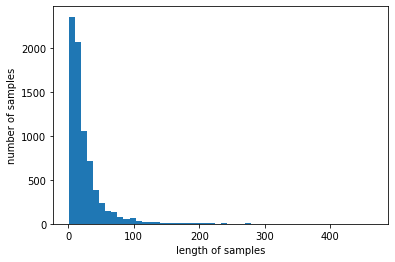

In [23]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [25]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 89.2962664517862


In [27]:
final = pad_sequences(X_train, maxlen=max_len)

<center><h2><b>Save File</b></h2></center>

In [30]:
final_ = list(map(lambda x:[x],final.astype(object)))

final_df = pd.DataFrame(final_,columns=['word'])
y_df = pd.DataFrame(y_train)

final_df = pd.concat([final_df, y_df], axis=1)
final_df.columns = ['word','label']

final_df.to_csv('/content/sample_data/khaiii_df.csv')